In [ ]:
import pandas as pd
import urllib
import pickle
import rassp
from rassp import netutil
from rdkit import Chem
import numpy as np
import torch
import matchms
import matplotlib.pyplot as plt

In [ ]:
from rassp import msutil,model
import sys
sys.modules['msutil'] = msutil
sys.modules['model'] = model

In [ ]:
base='https://people.cs.uchicago.edu/~ericj/rassp/'
files=[ 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model',    
'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta',
#'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model', 
#'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta',   
#'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.00000480.model',
#'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.meta'
]

for f in files:
    urllib.request.urlretrieve(f'{base}/{f}',f)

In [ ]:
from rassp.msutil.masscompute import FragmentFormulaPeakEnumerator

#valid_atoms = {1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53}
valid_atoms = {1, 6, 7, 8, 9, 15, 16, 17}
num_peaks_per_formula = 12
#max_formulae = 100000
max_formulae = 4096

ffe = FragmentFormulaPeakEnumerator(sorted(valid_atoms), use_highres=True, max_peak_num=num_peaks_per_formula)

def goodmol(mol):
        if len(mol.GetAtoms()) > 48:
            return False
        
        atoms = { a.GetAtomicNum() for a in mol.GetAtoms() }
        if not atoms < valid_atoms:
            return False
            
        f,m = ffe.get_frag_formulae(mol)
        if len(f) > max_formulae:
            return False

        return True


In [98]:
test = pd.read_parquet('test.pq')
test

,rdmol,spect,smiles
8,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[37.0, 14.99], [38.0, 57.95], [39.0, 333.7], ...",CC1=NN(C(=O)C1(C)C)C2=CC=CC=C2
19,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[15.0, 4.0], [26.0, 6.99], [27.0, 99.91], [28...",CCC(C(C)CC(C)C(=O)CC)O
20,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[25.0, 7.99], [26.0, 88.92], [27.0, 146.87], ...",CC=NC(CC#N)C#N
21,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[27.0, 0.5], [28.0, 0.5], [29.0, 2.0], [30.0,...",CCN(CC)CCNC(=O)C1=CC(=C(C=C1OC)N)Cl
26,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[24.0, 1.0], [25.0, 4.0], [26.0, 30.97], [27....",C1=CC(=NC(=C1)C=O)C=O
...,...,...,...
197094,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[14.0, 1.0], [15.0, 12.99], [16.0, 2.0], [17....",COC1=CC=C(C=C1)C2(CC2)C(=O)O
197096,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 2.0], [13.0, 3.0], [14.0, 5.99], [15.0...",C[Si](Cl)Cl
197099,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[41.0, 11.99], [43.0, 5.99], [44.0, 21.98], [...",C1=CC=C2C(=C1)C(=O)C(=C(C2=O)Cl)NC3=CC=C(C=C3)N
197102,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[36.0, 0.5], [37.0, 4.0], [39.0, 73.93], [41....",CC1=CC(=C(C(=C1)C)S(=O)(=O)NCCC2=NC3=CC=CC=C3N2)C


In [99]:
smalltest = test[[ goodmol(Chem.AddHs(Chem.Mol(m))) for m in test.rdmol ]]
smalltest

,rdmol,spect,smiles
8,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[37.0, 14.99], [38.0, 57.95], [39.0, 333.7], ...",CC1=NN(C(=O)C1(C)C)C2=CC=CC=C2
19,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[15.0, 4.0], [26.0, 6.99], [27.0, 99.91], [28...",CCC(C(C)CC(C)C(=O)CC)O
20,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[25.0, 7.99], [26.0, 88.92], [27.0, 146.87], ...",CC=NC(CC#N)C#N
26,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[24.0, 1.0], [25.0, 4.0], [26.0, 30.97], [27....",C1=CC(=NC(=C1)C=O)C=O
37,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[119.0, 79.93], [120.0, 819.26], [121.0, 79.9...",CCCCC1C(=O)N(C2=CC=CC=C2O1)O
...,...,...,...
197091,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[45.0, 37.97], [50.0, 27.97], [51.0, 55.95], ...",CC(C1=CC2=C(C=C1)OC(=N2)C3=CC=C(C=C3)Cl)C(=O)O
197093,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[17.0, 3.0], [18.0, 16.98], [27.0, 8.99], [28...",CCCC(=O)C1=CC(=C(C=C1O)O)O
197094,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[14.0, 1.0], [15.0, 12.99], [16.0, 2.0], [17....",COC1=CC=C(C=C1)C2(CC2)C(=O)O
197099,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[41.0, 11.99], [43.0, 5.99], [44.0, 21.98], [...",C1=CC=C2C(=C1)C(=O)C(=C(C2=O)Cl)NC3=CC=C(C=C3)N


In [ ]:
use_gpu=True
model='formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model'
meta='formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta'

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta,
    model,
    USE_CUDA=use_gpu,
    data_parallel=False,
)


In [100]:
sample = smalltest.sample(5000)
#sample = smalltest

mols = [ Chem.AddHs(Chem.Mol(m)) for m in sample.rdmol ]

predictions = predictor.pred(
    mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=1, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [09:51<00:00, 8.46it/s]


In [101]:
pred = predictions['pred_binned']
true = [ np.stack(list(t)) for t in sample.spect ]

In [102]:
def to_matchms_spec(s):
    return matchms.Spectrum(mz=s[:,0].astype(float),intensities=s[:,1].astype(float))

In [103]:
matchms.set_matchms_logger_level("ERROR")

#sim = matchms.similarity.CosineGreedy()
# SDP
# sim = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)

# normal DP
sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(len(true)) ]
sdp = np.array([ float(s['score']) for s in sdp ])


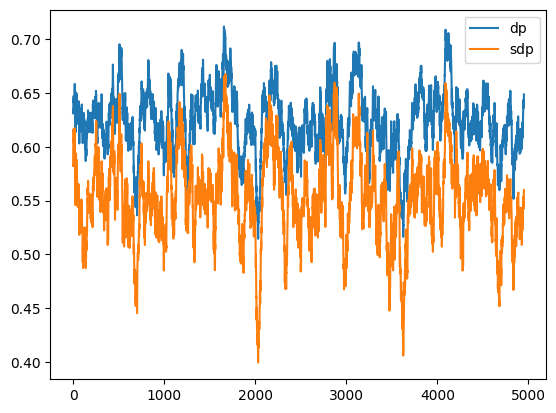

In [104]:
win = 50
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

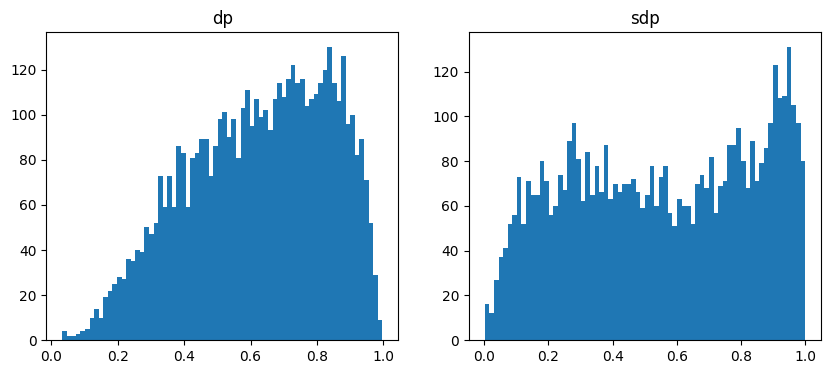

In [105]:
bins = 70
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='dp',bins=bins)
plt.title('dp')
plt.subplot(122)
plt.hist(sdp,label='sdp',bins=bins)
plt.title('sdp')
#lt.legend()
plt.show()

In [106]:
np.mean(dp),np.std(dp)

(0.6247502462593122, 0.21121839347367566)

In [107]:
np.mean(sdp),np.std(sdp)

(0.5535273248346485, 0.283938451422905)